Relaxed entropy dual, where we estimate $\varphi$ only, replacing $\psi$ with first order optimality condition.

In [1]:
import torch
from torch import nn
from torch import Tensor


class PosLinear(torch.nn.Linear):
    def forward(self, x: Tensor) -> Tensor:
        gain =  1 / x.size(-1)
        return nn.functional.linear(x, torch.nn.functional.softplus(self.weight), self.bias) * gain

class PICNN(nn.Module):
    def __init__(self,
            x_dimension: int,
            y_dimension: int,
            u_dimension: int,
            z_dimension: int,
            output_dimension: int,
            number_of_hidden_layers: int
        ):
        super(PICNN, self).__init__()


        # Activations:
        self.z_activation = nn.Softplus()
        self.u_activation = nn.ELU()
        self.positive_activation = nn.Softplus()

        # First layer
        self.first_linear_layer_tilde = nn.Linear(x_dimension, u_dimension)
        self.first_linear_layer_yu = nn.Linear(x_dimension, y_dimension)
        self.first_linear_layer_y = nn.Linear(y_dimension, z_dimension, bias=False)
        self.first_linear_layer_u = nn.Linear(x_dimension, z_dimension, bias=False)

        # Iterations:
        self.linear_layer_tilde = nn.ModuleList([
                nn.Linear(u_dimension, u_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_uz = nn.ModuleList([
            nn.Linear(u_dimension, z_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_z = nn.ModuleList([
            PosLinear(z_dimension, z_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_uy = nn.ModuleList([
            nn.Linear(u_dimension, y_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_y = nn.ModuleList([
            nn.Linear(y_dimension, z_dimension, bias=False)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_u = nn.ModuleList([
            nn.Linear(u_dimension, z_dimension, bias=False)
                for _ in range(number_of_hidden_layers)
        ])
        self.number_of_hidden_layers = number_of_hidden_layers

        # Last layer:
        self.last_linear_layer_uz = nn.Linear(u_dimension, z_dimension)
        self.last_linear_layer_z = PosLinear(z_dimension, output_dimension)
        self.last_linear_layer_uy = nn.Linear(u_dimension, y_dimension)
        self.last_linear_layer_y = nn.Linear(y_dimension, output_dimension, bias=False)
        self.last_linear_layer_u = nn.Linear(u_dimension, output_dimension, bias=False)


    def forward(self, x, y):
        # First layer:
        u = self.u_activation(
            self.first_linear_layer_tilde(x)
        )
        z = self.z_activation(
            self.first_linear_layer_y(
                y * self.first_linear_layer_yu(x)
            ) +
            self.first_linear_layer_u(x)
        )

        # Iterations:
        for iteration_number in range(self.number_of_hidden_layers):
            u, z = (
                self.u_activation(
                    self.linear_layer_tilde[iteration_number](u)
                ),
                self.z_activation(
                    self.linear_layer_z[iteration_number](
                        z * self.positive_activation((self.linear_layer_uz[iteration_number](u)))
                    ) + \
                    self.linear_layer_y[iteration_number](
                        y * self.linear_layer_uy[iteration_number](u)
                    ) + \
                    self.linear_layer_u[iteration_number](u)
                )
            )

        # Last layer:
        output = self.last_linear_layer_z(
            z * self.positive_activation(self.last_linear_layer_uz(u))
        ) + \
        self.last_linear_layer_y(
            y * self.last_linear_layer_uy(u)
        ) + \
        self.last_linear_layer_u(u)

        return output

def torch_sphere_uniform(n, d, **kwargs):
    """Generate n points inside the d-dimensional sphere."""
    random_vectors = torch.randn(n, d, **kwargs)
    vectors_norms = torch.norm(random_vectors, dim=1, keepdim=True)
    radius = torch.pow(torch.rand(n, 1, **kwargs), 1. / d)
    return radius * random_vectors / vectors_norms

In [2]:
from data_utils import create_joint_x_y
import numpy as np

num_points_to_generate = 1000
X, Y = create_joint_x_y(num_points_to_generate)

n, d = Y.shape
m = n

phi_network = PICNN(
    x_dimension=X.shape[1],
    y_dimension=Y.shape[1],
    u_dimension=20,
    z_dimension=20,
    output_dimension=1,
    number_of_hidden_layers=2,
)

In [3]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
epsilon = 1e-5
num_epochs = 1000

phi_network.to(**device_and_dtype_specifications)
phi_network_optimizer = torch.optim.Adam([dict(params=phi_network.parameters())], lr=0.01)

X, Y = create_joint_x_y(num_points_to_generate)
X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
dataset_size = num_points_to_generate
batch_size = 64


def estimate_psi(X_tensor, Y_tensor, U_tensor, phi_net, epsilon=0.1):
        """
        Estimate the dual objective term for entropy estimation.

        This function implements the core calculation based on nearest neighbors and learned
        potential functions phi and psi. It offers an option to oversample some x's to better approximate P(Y|X)

        Args:
        X_tensor (torch.Tensor): The input tensor for x, with shape [n, p].
        Y_tensor (torch.Tensor): The input tensor for y, with shape [n, q].
        U_tensor (torch.Tensor): The tensor of oversampled variables u, with shape [m, q].
        phi_net (nn.Module): The neural network representing the potential function phi(u, x).
        psi_net (nn.Module): The neural network representing the potential function psi(x, y).
        k (int, optional): The number of nearest neighbors to use. Defaults to 5.
        epsilon (float, optional): A small positive constant for the calculation. Defaults to 0.1.

        Returns:
        torch.Tensor: A scalar tensor representing the estimated dual value.
        """
        # Get dimensions from input tensors
        n, _ = X_tensor.shape
        m, _ = U_tensor.shape

        U_expanded = U_tensor.unsqueeze(0).expand(n, -1, -1)  # Shape: [n, m, q] [:, i, :] = u_i
        X_expanded_for_U = X_tensor.unsqueeze(1).expand(-1, m, -1)  # Shape: [n, m, p] [i, :, :] = x_i

        phi_vals = phi_net(X_expanded_for_U, U_expanded).squeeze(-1)  # Shape: [n, m] [i, j] = phi(u_i, x_j)
        cost_matrix = Y_tensor @ U_tensor.T # Shape: [n, m] [i, j] = y_j @ u_i

        slackness = cost_matrix - phi_vals    # Shape: [n, m]

        log_mean_exp = torch.logsumexp(slackness / epsilon, dim=1, keepdim=True) \
                - torch.log(torch.tensor(m, device=slackness.device, dtype=slackness.dtype))

        psi_estimate = epsilon * log_mean_exp

        return psi_estimate


for epoch_idx in range(1, num_epochs):

        phi_network.zero_grad()

        yindexes = torch.randint(0, dataset_size, (batch_size,))

        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch = torch.randn(batch_size, Y_batch.shape[1], **device_and_dtype_specifications)

        phi = phi_network(X_batch, U_batch)
        psi = estimate_psi(
                X_tensor=X_batch,
                Y_tensor=Y_batch,
                U_tensor=U_batch,
                phi_net=phi_network,
                epsilon=epsilon
        )

        objective = torch.mean(phi) + torch.mean(psi)

        objective.backward()
        phi_network_optimizer.step()
        print(objective.item(), epoch_idx)

_ = phi_network.eval()

14.481403746221485 1
14.587451276269897 2
15.742880936160503 3
14.93905336155037 4
14.73060682580207 5
15.801171894975841 6
17.867498219678804 7
10.877191605909085 8
11.458810425795546 9
9.726177338458832 10
10.698298148712801 11
9.474913549123489 12
8.691394402461562 13
6.596242924004958 14
5.505497068220388 15
8.782285754383722 16
5.510752178735704 17
9.023479075004275 18
6.985705357478508 19
1.1854013738573368 20
4.922705925967115 21
6.0937351615610815 22
4.440734840420051 23
5.855391823304553 24
5.66768715023891 25
4.2759272359811735 26
6.607117344876696 27
4.841408316783937 28
4.109073602666241 29
5.211048455457439 30
4.730500347755118 31
4.756930778660105 32
3.065511780598318 33
3.3605352286319574 34
4.117213157910912 35
4.705788835888908 36
4.876331375053423 37
4.172188493772092 38
4.5220375725085695 39
3.4827021159154343 40
4.164237106602091 41
4.902408269376742 42
4.256913513495249 43
3.0332703006014197 44
3.5286269331924722 45
4.597247502533101 46
3.2530878043509266 47
3.2079

In [4]:
import torch
import torch.distributions
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
num_epochs = 4000

multivariate_normal = torch.distributions.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2))

phi_network.to(**device_and_dtype_specifications)
phi_network_optimizer = torch.optim.Adam([dict(params=phi_network.parameters())], lr=0.01)

X, Y = create_joint_x_y(num_points_to_generate)
X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
dataset_size = num_points_to_generate
batch_size = 256

def estimate_U_tensor(X_tensor, Y_tensor, phi_net, number_of_iterations=100):
        U_tensor = torch.ones_like(Y_tensor, requires_grad=True)
        optimizer = torch.optim.LBFGS([U_tensor],
                lr=0.1,
                history_size=10,
                max_iter=number_of_iterations,
                line_search_fn="strong_wolfe",
                tolerance_change=1e-5
        )

        def closure():
                optimizer.zero_grad()
                objective = (phi_net(X_tensor, U_tensor) - (U_tensor*Y_tensor).sum(dim=1, keepdims=True) - multivariate_normal.log_prob(U_tensor)).sum()
                objective.backward()
                return objective

        optimizer.step(closure)

        return U_tensor

for epoch_idx in range(1, num_epochs):

        yindexes = torch.randint(0, dataset_size, (batch_size,))
        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch = torch.randn(
                batch_size, Y_batch.shape[1],
                **device_and_dtype_specifications
        )

        tilde_U_batch = estimate_U_tensor(
                X_tensor=X_batch,
                Y_tensor=Y_batch,
                phi_net=phi_network,
                number_of_iterations=100,
        )

        phi_network.zero_grad()

        phi = phi_network(X_batch, U_batch)
        psi = (tilde_U_batch*Y_batch).sum(dim=1, keepdims=True) - phi_network(X_batch, tilde_U_batch)

        objective = torch.mean(psi) + torch.mean(phi)
        objective.backward()
        phi_network_optimizer.step()
        print(objective.item(), epoch_idx)

_ = phi_network.eval()

3.186075025610503 1
5.2136413918193085 2
2.205145377487206 3
3.0603942031326365 4
2.786979058035593 5
2.312969708622566 6
2.7944877710425313 7
2.2308077234057393 8
2.5264298648450634 9
2.5038845894413235 10
3.053672070332203 11
3.070360292864981 12
2.988484201906946 13
3.185907213452559 14
3.091867786111983 15
2.947607922321204 16
3.28549859918531 17
3.3337001716070134 18
2.4764282562031106 19
3.1637987604559683 20
3.3127969351570847 21
2.2817549457334607 22
2.471824891334789 23
2.3115857848778916 24
1.1424758042327383 25
3.147431715610079 26
3.2919063919761413 27
2.5883938891185636 28
2.5801810886337684 29
2.3528681742507835 30
2.382968660699575 31
2.2034192169340088 32
2.430937974144296 33
2.2109634639589277 34
3.126792102676319 35
2.531008169558323 36
3.227288511165195 37
2.677265794928239 38
2.1359541458716507 39
2.7705796848667674 40
1.833498240009419 41
3.234105353085031 42
2.9163693491260787 43
3.0513407253641205 44
2.8108245168066155 45
2.4247536744220604 46
2.086140367163871 4

KeyboardInterrupt: 

In [8]:
# Change to %matplotlib qt to have interactive plots
%matplotlib qt
import matplotlib.pyplot as plt
from data_utils import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):

    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(20, 1))
    _, y_x_gt = create_conditional_x(n_points=20, x_value=x_/100)
    y = torch.tensor(y_x_gt, **device_and_dtype_specifications)

    colors = ['red', 'purple', 'green']
    radii = [0.1, 0.5, 1.]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 20)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True
        potential = phi_network(x, u_tensor)
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        z_line = x.detach().cpu().numpy()
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

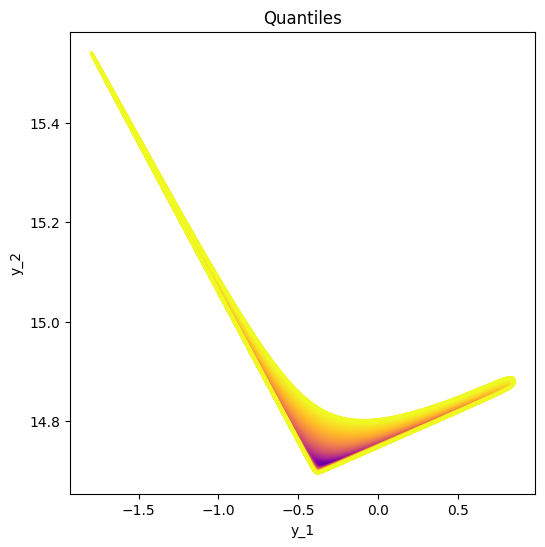

In [9]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title('Quantiles')
ax1.set_xlabel('y_1')
ax1.set_ylabel('y_2')
x = torch.tensor([2.4], **device_and_dtype_specifications)[:, None]

radii = np.linspace(0.01, 1, 1000)
colors = matplotlib.colormaps['plasma'](radii/1)

for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 1000)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        potential = phi_network(x.repeat(u_tensor.shape[0], 1), u_tensor)

        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)
